In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from DataPreparation import DataPreparation
import warnings

In [2]:
pics = './images'

In [3]:
df = pd.read_csv('./data/balanced_dataframe.csv', index_col=None)
df.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MaxPartialCharge,MinPartialCharge,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,...,fr_Nhpyrrole,fr_aldehyde,fr_amidine,fr_aryl_methyl,fr_benzene,fr_benzodiazepine,fr_diazo,fr_halogen,fr_hdrzine,label
0,10.337455,-1.272753,23.375000,505.329,79.918731,10.123678,9.103951,-0.051090,3.459112,1.375036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,10.335047,-1.271941,23.375000,505.329,79.918731,10.124302,9.103026,-0.051090,3.450909,1.367373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,10.333078,-1.271281,23.375000,505.329,79.918731,10.124439,9.103025,-0.051090,3.448581,1.360843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,10.355554,-1.235039,25.218750,440.504,16.562573,9.897992,5.825210,-0.051059,3.346646,1.323034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,6.090409,0.226017,12.285714,362.614,79.918731,10.103988,9.101988,0.552888,3.020157,1.976391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
X = df.drop(columns=['label'])
y = df['label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y
                                                    )
y_test.value_counts()

label
0    915
1    915
Name: count, dtype: int64

In [6]:
data_preparation = DataPreparation(X_train, X_test, y_train, y_test)

# # get scaled clean data
# # use StandartScaler
X_train, X_test, y_train, y_test = data_preparation.clean_dataset()

In [1]:
X.shape

NameError: name 'X' is not defined

In [8]:
X_train.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MaxPartialCharge,MinPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_LOGPLOW,...,fr_HOCCN,fr_Nhpyrrole,fr_aldehyde,fr_amidine,fr_aryl_methyl,fr_benzene,fr_benzodiazepine,fr_diazo,fr_halogen,fr_hdrzine
0,0.559602,0.611651,-0.422226,1.211841,-0.585803,0.059382,-0.137254,1.054514,-1.179718,0.135853,...,-0.594943,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,-0.195439,-0.337585
1,0.428572,0.503159,-0.942970,-0.375029,0.310526,0.386482,0.709755,0.766113,-0.162462,-0.134427,...,1.645274,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,-0.195439,-0.337585
2,-2.415560,0.933966,-0.864290,-1.419216,0.500732,0.417429,1.502564,-0.105369,0.984164,-0.136860,...,-0.594943,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,-0.195439,-0.337585
3,-0.573217,-0.226000,0.976004,0.700514,-0.580937,0.172790,0.014556,0.683626,-0.530271,-0.111818,...,1.645274,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,20.096993,-0.337585
4,0.450529,0.336894,-0.687366,0.318551,-0.573277,0.523207,0.547022,1.281237,-1.038073,-0.097077,...,-0.594943,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,-0.195439,2.823571


In [57]:
lr = LogisticRegression(max_iter=200)
scoring_lr = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
param_grid_lr = {'C': [0.01, 0.1, 10, 100],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
warnings.filterwarnings('ignore')
cv_lr = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
warnings.filterwarnings('ignore')
grid_lr = GridSearchCV(lr, 
                    param_grid_lr, 
                    cv=cv_lr, 
                    scoring=scoring_lr, 
                    refit='AUC', 
                    verbose=1, 
                    n_jobs=-1,
                    # error_score='raise'
                    )


%time grid_lr.fit(X_train, y_train)

print()
print(grid_lr.best_params_)

y_pred = grid_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

score = roc_auc_score(y_test, y_pred)
print("Mean ROC AUC:", score)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/codespace/.local/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/codespace/.local/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/codespace/.local/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/codespace/.local/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/codespace/.local/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding e

CPU times: user 1.55 s, sys: 606 ms, total: 2.16 s
Wall time: 15.6 s

{'C': 10, 'solver': 'newton-cg'}
Accuracy: 0.9377049180327869
Mean ROC AUC: 0.9377049180327869


In [10]:
y_pred = grid_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("For test set:")

print(classification_report(y_test, y_pred))

For test set:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       915
           1       0.93      0.96      0.95       915

    accuracy                           0.94      1830
   macro avg       0.95      0.94      0.94      1830
weighted avg       0.95      0.94      0.94      1830



In [11]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
clf = grid_lr.best_estimator_
# lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
X_new_test = model.transform(X_test)
X_new.shape

(4270, 34)

In [14]:
clf1 = LogisticRegression(C=100, solver='newton-cg')
clf1 = clf1.fit(X_new, y_train)
preds_train = clf1.predict(X_new)
preds_test = clf1.predict(X_new_test)

In [15]:
print(classification_report(y_train, preds_train))
print(classification_report(y_test, preds_test))

accuracy = accuracy_score(y_train, preds_train)
print("Accuracy:", accuracy)

score = roc_auc_score(y_train, preds_train)
print("Mean ROC AUC:", score)

accuracy = accuracy_score(y_test, preds_test)
print("Accuracy:", accuracy)

score = roc_auc_score(y_test, preds_test)
print("Mean ROC AUC:", score)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2135
           1       0.92      0.94      0.93      2135

    accuracy                           0.93      4270
   macro avg       0.93      0.93      0.93      4270
weighted avg       0.93      0.93      0.93      4270

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       915
           1       0.91      0.95      0.93       915

    accuracy                           0.93      1830
   macro avg       0.93      0.93      0.93      1830
weighted avg       0.93      0.93      0.93      1830

Accuracy: 0.9309133489461359
Mean ROC AUC: 0.9309133489461358
Accuracy: 0.9289617486338798
Mean ROC AUC: 0.9289617486338798


In [16]:
y_pred = grid_lr.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
print("For train set:")

print(classification_report(y_train, y_pred))

For train set:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2135
           1       0.94      0.96      0.95      2135

    accuracy                           0.95      4270
   macro avg       0.95      0.95      0.95      4270
weighted avg       0.95      0.95      0.95      4270



In [17]:
clf = grid_lr.best_estimator_

<Axes: ylabel='Feature'>

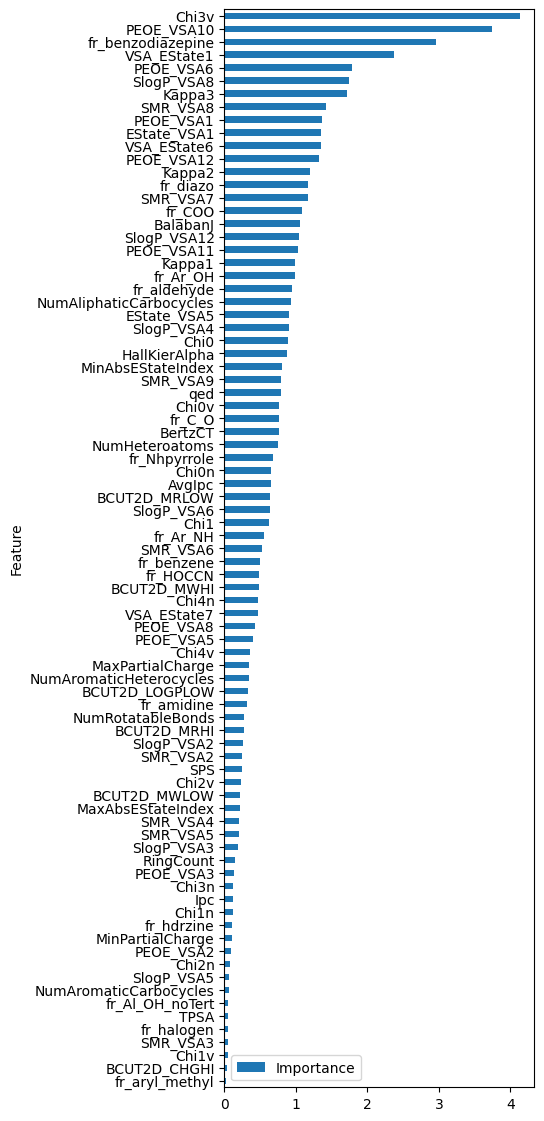

In [18]:
avg_importance = np.mean(np.abs(clf.coef_), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(4, 14))

In [48]:
best_20_feat = feature_importance.iloc[:, :]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X[best_20_feat['Feature']], y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y
                                                    )

In [50]:
clf = LogisticRegression(C=100, solver='newton-cg')
clf = clf.fit(X_train, y_train)
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)

In [51]:
print(classification_report(y_train, preds_train))
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2135
           1       0.92      0.95      0.93      2135

    accuracy                           0.93      4270
   macro avg       0.93      0.93      0.93      4270
weighted avg       0.93      0.93      0.93      4270

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       915
           1       0.91      0.94      0.93       915

    accuracy                           0.93      1830
   macro avg       0.93      0.93      0.93      1830
weighted avg       0.93      0.93      0.93      1830

